## Protocol Analysis

It would probably be good to make these actual python libraries. Oh well.

In [953]:
# First extract logs with "PERF" from the client/receiver logs

from pathlib import Path

filename="prod_c4_if80.log"

if not Path(filename).exists():
    !cat ../logs/replica*.log ../logs/client*.log | grep PERF >{filename}

In [954]:
# Basic log parsing

import re
import datetime 

def parse_time(line):
    match = re.search(f"([0-9]*:[0-9]*:[0-9]*.[0-9]*)", line)
    time_str = match.group(1);
    return datetime.datetime.strptime(time_str, "%H:%M:%S.%f")

def parse_tags(line):
    tags = {}
    line = line.split("PERF ")[1]
    for token in line.split():
        [tag, value] = token.split("=")
        tags[tag] = value
        try:
            tags[tag] = int(value)
        except ValueError as verr:
            pass
            
    return tags
        
def parse_line(line):
    time = parse_time(line)
    tags = parse_tags(line)

    tags["time"] = time
    return tags 

In [955]:
events = []

with open(filename) as f:
    for line in f:
        events.append(parse_line(line))

In [956]:
events = sorted(events, key=lambda x: x['time'])
commits = list(filter(lambda x: x["event"] == "commit", events))

In [957]:
# Look at each client commit, make sure there are no two clients ops on the same seq
from collections import Counter

counts = Counter(c["seq"] for c in commits)
for seq in counts:
    if counts[seq] > 1:
        print(f"Sequence {seq} has different commits!")

In [958]:
# Ensure all client operations are committed
n_clients = 2

for c_id in range(n_clients):
    c_commits = filter(lambda x: x["client_id"] == c_id, commits)
    seq = sorted(c["client_seq"] for c in c_commits)

    for x, y in zip(seq, seq[1:]):
        if (y-x) > 1:
            print(f"Client {c_id} missed commits between {x}-{y}")
        
        if x == y:
            print(f"Client {c_id} repeated commits {x}")


In [959]:
# Get general stats
runtime = (commits[-1]["time"] - commits[0]["time"]).total_seconds()
print(f"Runtime: {runtime:.3f} s")
print(f"Total Throughput: {len(commits) / runtime:.2f} req/s")

print(f"Num commits: {len(commits)}")
print(f"Average latency: {sum(c['latency'] for c in commits) / len(commits):.0f} us")

fast = list(filter(lambda x: x["path"] == "fast", commits))
normal = list(filter(lambda x: x["path"] == "normal", commits))
slow = list(filter(lambda x: x["path"] == "slow", commits))

print("Fast path:")
print(f"\tNum commits: {len(fast)}")
if len(fast) > 0:
    print(f"\tAverage latency: {sum(c['latency'] for c in fast) / len(fast):.0f} us")


print("Normal path:")
print(f"\tNum commits: {len(normal)}")
if len(normal) > 0:
    print(f"\tAverage latency: {sum(c['latency'] for c in normal) / len(normal):.0f} us")

print("Slow path:")
print(f"\tNum commits: {len(slow)}")
if len(slow) > 0:
    print(f"\tAverage latency: {sum(c['latency'] for c in slow) / len(slow):.0f} us")



Runtime: 31.367 s
Total Throughput: 1019.71 req/s
Num commits: 31985
Average latency: 292052 us
Fast path:
	Num commits: 21075
	Average latency: 168554 us
Normal path:
	Num commits: 10592
	Average latency: 486467 us
Slow path:
	Num commits: 318
	Average latency: 2001072 us


In [960]:
# Get the throughput over periods of 100ms every 10ms  

import numpy as np

w_size = 0.2 #s
resolution = 0.1 #s

start_time = commits[0]["time"]
end = (commits[-1]["time"] - start_time).total_seconds()

for c in commits:
     c["t"] = (c["time"] - start_time).total_seconds()

w_start = 0
i = 0
j = 0

commit_counts = []
commit_paths = []

while w_start + w_size < end:
    while (commits[i]["t"] < w_start):
        i += 1
    while (commits[j]["t"] <= w_start + w_size):
        j += 1

    commit_counts.append(j - i)

    if (j > i):
        path_counts = Counter(c["path"] for c in commits[i:j])
        commit_paths.append(path_counts.most_common(1)[0][0])
    else:
        commit_paths.append("slow")
    
    w_start += resolution


times = np.arange(0, end - w_size, resolution)
throughput = np.array(commit_counts) / w_size

def pathToColor(path):
    if path == "fast": return 'g'
    elif path == "normal": return 'b'
    elif path == "slow": return 'r'

colors=[ pathToColor(path) for path in commit_paths ]

In [961]:
# Get first fallback start time for each instance

fallback_starts = list(filter(lambda x: x["event"] == "fallback_start" and x["replica_id"] == 0, events))

fallback_starts_t = [
    (x["time"] - start_time).total_seconds()
    for x in fallback_starts
]

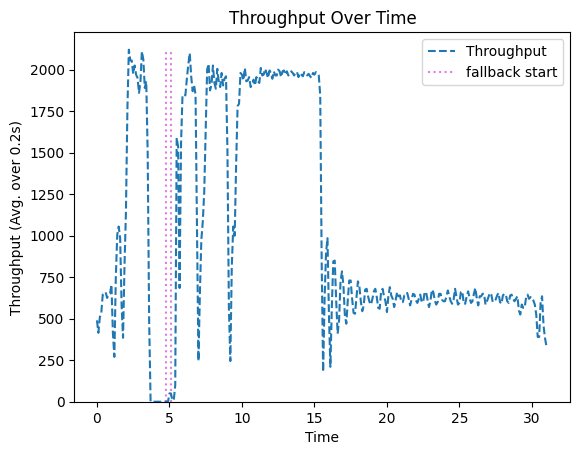

In [962]:
# Plot throughput over time
import matplotlib.pyplot as plt


plt.plot(times, throughput, label='Throughput', linestyle="--")
plt.vlines(fallback_starts_t, min(throughput), max(throughput), color='m', linestyle='dotted', label='fallback start', alpha=0.5)

plt.title('Throughput Over Time')
plt.xlabel('Time')
plt.ylabel(f'Throughput (Avg. over {w_size}s)')
plt.legend()

plt.ylim(0, None)
plt.show()

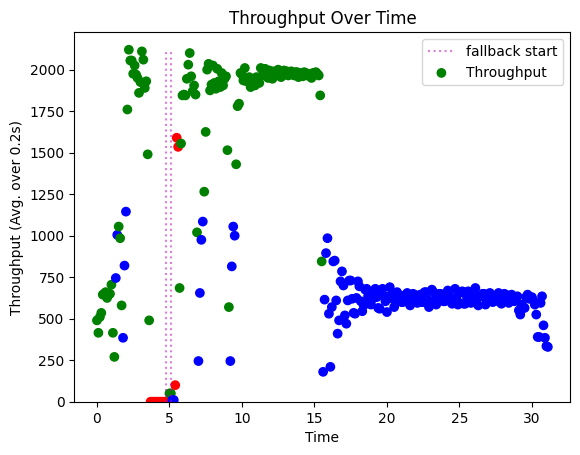

In [963]:
# Same graph, but with indications of which type of commit was done


plt.vlines(fallback_starts_t, min(throughput), max(throughput), color='m', linestyle='dotted', label='fallback start', alpha=0.5)
plt.scatter(times, throughput, label='Throughput', alpha=1, c=colors)


plt.title('Throughput Over Time')
plt.xlabel('Time')
plt.ylabel(f'Throughput (Avg. over {w_size}s)')
plt.legend()
plt.ylim(0, None)
plt.show()